In [1]:
import sys
sys.path.append('C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src')
from Experiment import *
from AEC_Badel import *
from GIF import *
from Filter_Rect_LogSpaced import *
from Filter_Rect_LinSpaced import *
import pickle
import matplotlib.pyplot as plt
from Filter_Exps import * 


In [2]:
def get_gamma_factor(modelspks, dataspks, delta, time, dt, rate_correction=True):
    """
    Calculate gamma factor between model and target spike trains,
    with precision delta.

    Parameters
    ----------
    model: `list` or `~numpy.ndarray`
        model trace
    data: `list` or `~numpy.ndarray`
        data trace
    delta: `~brian2.units.fundamentalunits.Quantity`
        time window
    dt: `~brian2.units.fundamentalunits.Quantity`
        time step
    time: `~brian2.units.fundamentalunits.Quantity`
        total time of the simulation
    rate_correction: bool
        Whether to include an error term that penalizes differences in firing
        rate, following `Clopath et al., Neurocomputing (2007)
        <https://doi.org/10.1016/j.neucom.2006.10.047>`_.

    """
    model = np.array(modelspks)
    data = np.array(dataspks)

    model = np.array(np.int32(model / dt), dtype=int)
    data = np.array(np.int32(data / dt), dtype=int)
    delta_diff = int(np.int32(delta / dt))

    model_length = len(model)
    data_length = len(data)
    # data_rate = firing_rate(data) * Hz
    data_rate = data_length / time
    model_rate = model_length / time

    if model_length > 1:
        bins = .5 * (model[1:] + model[:-1])
        indices = np.digitize(data, bins)
        diff = np.abs(data - model[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = np.sum(matched_spikes)
    elif model_length == 0:
        coincidences = 0
    else:
        indices = [np.amin(abs(model - data[i])) <= delta_diff for i in np.arange(data_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * data_length * data_rate
    norm = .5*(1 - 2 * data_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(model_length + data_length))

    if rate_correction:
        rate_term = 1 + 2*np.abs((data_rate - model_rate)/data_rate)
    else:
        rate_term = 1
    # return gamma

    return np.clip(rate_term - gamma, 0, np.inf)


In [3]:
"""
This file shows how to fit a GIF to some experimental data.
More instructions are provided on the website. 
"""
############################################################################################################
# STEP 1: LOAD EXPERIMENTAL DATA
############################################################################################################
myExp = Experiment('Experiment 1', 0.05)

#Inhibitory
with open("G:/My Drive/Bernstein/170725_NC_82_INH.pickle",'rb') as f:
    data = pickle.load(f)
I_data = data['I'][:120*20000]
V_data = data['V'][:120*20000]
spikes_data = data['spikes']    

# #Excitatory
# with open("G:/My Drive/Bernstein/170815_NC_109_EXC.pickle",'rb') as f:
#     data = pickle.load(f)
# I_data = data['I'][:120*20000]
# V_data = data['V'][:120*20000]
# spikes_data = data['spikes']    

# Load AEC data
myExp.setAECTrace(V_data[:int(10*20000)],1e-3,I_data[:int(10*20000)] ,1e-12, 10000.0, FILETYPE='Array')

# Load training set data
myExp.addTrainingSetTrace(V_data,1e-3,I_data, 1e-12, 120000.0, FILETYPE='Array')


## Perform AEC

In [4]:
############################################################################################################
# STEP 2: ACTIVE ELECTRODE COMPENSATION
############################################################################################################

# Create new object to perform AEC
myAEC = AEC_Badel(myExp.dt)

# Define metaparametres
myAEC.K_opt.setMetaParameters(length=150.0, binsize_lb=myExp.dt, binsize_ub=2.0, slope=30.0, clamp_period=1.0)
myAEC.p_expFitRange = [3.0,150.0]  
myAEC.p_nbRep = 15     

# Assign myAEC to myExp and compensate the voltage recordings
myExp.setAEC(myAEC)  
myExp.performAEC()  

plt.plot(myExp.trainingset_traces[0].V[:1*20000],label='AEC corrected')
plt.plot(V_data[:1*20000],label='Original')
plt.legend()
plt.show()
# # Plot AEC filters (Kopt and Ke)
# myAEC.plotKopt()
# myAEC.plotKe()

# # Plot training and test set
# myExp.plotTrainingSet()
# myExp.plotTestSet()



PERFORM ACTIVE ELECTRODE COMPENSATION (Badel method)...

Estimate electrode properties...
Repetition  1  R_e (MOhm) = 49.78
Repetition  2  R_e (MOhm) = 52.26
Repetition  3  R_e (MOhm) = 48.68
Repetition  4  R_e (MOhm) = 53.37
Repetition  5  R_e (MOhm) = 51.57
Repetition  6  R_e (MOhm) = 52.00
Repetition  7  R_e (MOhm) = 48.09
Repetition  8  R_e (MOhm) = 52.50
Repetition  9  R_e (MOhm) = 53.70


KeyboardInterrupt: 

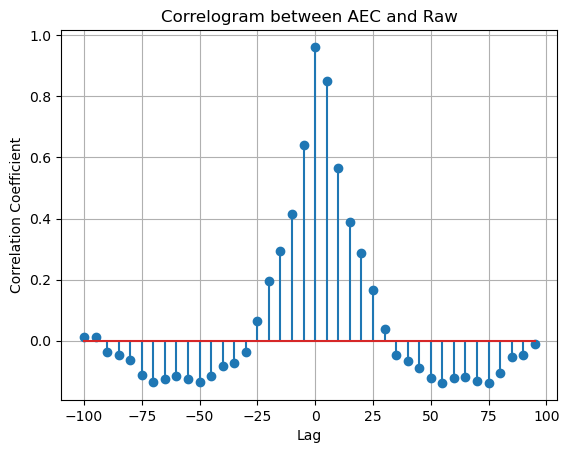

In [ ]:
from scipy import signal
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

fig,ax = plt.subplots()
plot_correlations(myExp.trainingset_traces[0].V[:1*20000],V_data[:1*20000],100,'AEC','Raw',ax)

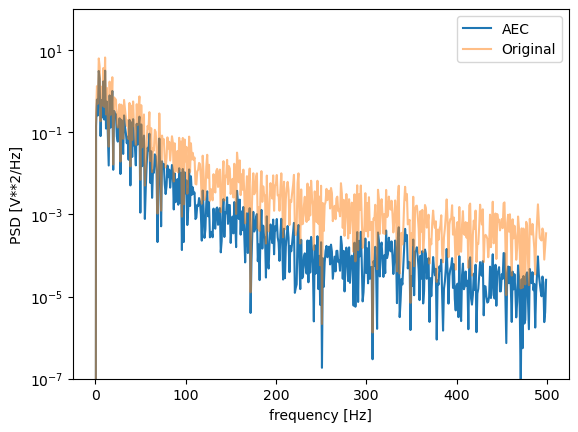

In [ ]:
fs = 20000
x = myExp.trainingset_traces[0].V[:1*20000]
f, Pxx_den = signal.periodogram(x, fs)
y = V_data[:1*20000]
f, Pyy_den = signal.periodogram(y, fs)

plt.semilogy(f[:500], Pxx_den[:500],label='AEC')
plt.semilogy(f[:500], Pyy_den[:500],alpha=0.5,label='Original')

plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

## Fit the data

In [20]:
############################################################################################################
# STEP 3: FIT GIF MODEL TO DATA
############################################################################################################

# Create a new object GIF 
myGIF = GIF(0.05)

# Define parameters
myGIF.Tref = 4.0  

#Rectangular Filter
myGIF.eta = Filter_Rect_LogSpaced()
myGIF.eta.setMetaParameters(length=500.0, binsize_lb=2.0, binsize_ub=1000.0, slope=4.5)

myGIF.gamma = Filter_Rect_LogSpaced()
myGIF.gamma.setMetaParameters(length=500.0, binsize_lb=5.0, binsize_ub=1000.0, slope=5.0)


# Exp Filter
myGIF.eta = Filter_Exps()
myGIF.eta.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])
myGIF.gamma = Filter_Exps()
myGIF.gamma.setFilter_Timescales([1.0, 5.0, 30.0, 70.0, 100.0, 500.0])

# Define the ROI of the training set to be used for the fit (in this example we will use only the first 100 s)
myExp.trainingset_traces[0].setROI([[0,100000.0]])

# To visualize the training set and the ROI call again
myExp.detectSpikes_python()
# myExp.plotTrainingSet()





Detect spikes!
Done!


In [21]:
# Perform the fit
myGIF.fit(myExp, DT_beforeSpike=5.0)


################################
# Fit GIF
################################
Estimate voltage reset (Tref = 4.0 ms)...
Done! Vr = -55.19 mV (computed on 365 spikes)

GIF MODEL - Fit subthreshold dynamics...
Compute X matrix for repetition 1
434

Perform linear regression...

-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.395
R (MOhm):	119.420
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.093
Tref (ms):	4.000
Vr (mV):	-55.185
Vt* (mV):	-48.000
DV (mV):	0.500
-------------------------

Percentage of variance explained (on dV/dt): 18.47
Percentage of variance explained (on V): 93.73

GIF MODEL - Fit static threshold...

Maximize log-likelihood (bit/spks)...
-0.3127397256359752
3.266469189505907
3.9277725674531783
4.347818214479025
4.640051253678671
4.853552197235731
5.0142632476423925
5.137631435087021
5.233617161679526
5.309015091508068
5.3686543163141796
5.416072711264334
5.594528882930783
5.609819985777758
5.609889783371017

Converged after 16 it


-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	3.395
R (MOhm):	119.420
C (nF):		0.028
gl (nS):	0.008374
El (mV):	-52.093
Tref (ms):	4.000
Vr (mV):	-55.185
Vt* (mV):	-61.273
DV (mV):	2.135
-------------------------



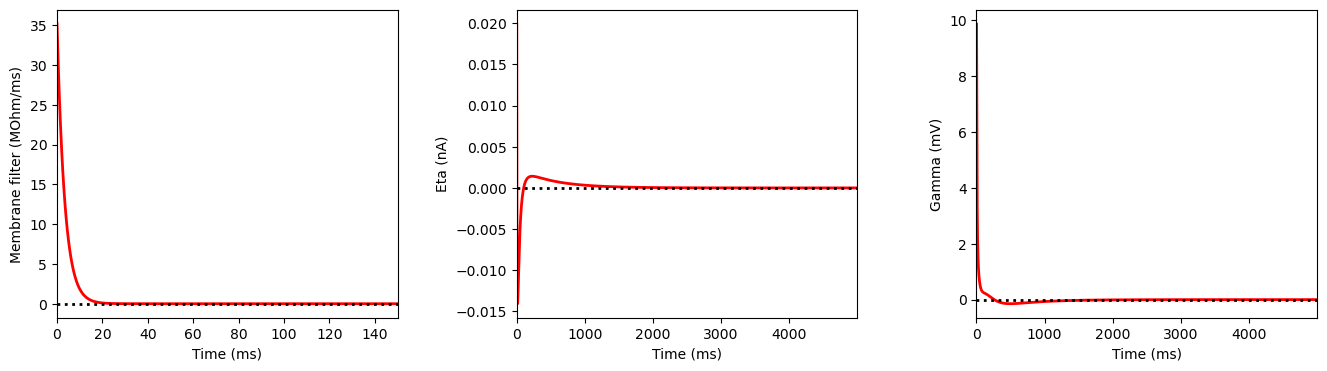

In [22]:
# Plot the model parameters
myGIF.printParameters()  
myGIF.plotParameters()   

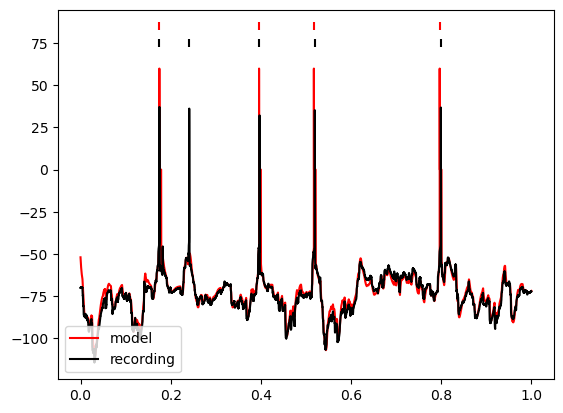

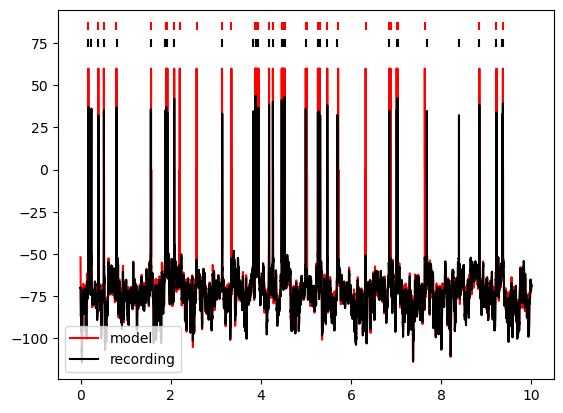

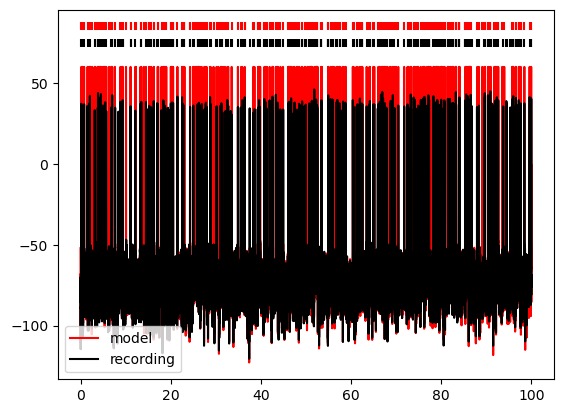

In [23]:

I = myExp.trainingset_traces[0].I
V_exp = myExp.trainingset_traces[0].V
spks = myExp.trainingset_traces[0].spks*myExp.dt
(time, V_model, I_a, V_t, S_model) = myGIF.simulate(I, myGIF.El)

time  = time/1000

def getBinarySpikeTrain(V,spikes,dt,type='zero'):
    spikeinds  = np.int32(spikes/dt)
    if type=='zero':
        b_spikes = np.zeros(len(V))

    else:
        b_spikes = np.zeros(len(V))*np.nan
    b_spikes[spikeinds] =1
    return b_spikes


spks_model = getBinarySpikeTrain(V_model,S_model,myExp.dt,type='nan')
spks_data = getBinarySpikeTrain(V_exp,spks,myExp.dt,type='nan')


plot_time = 1 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



plot_time = 10 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()


plot_time = 100 # s
plt.plot(time[:plot_time*20000],V_model[:plot_time*20000],c='red',label='model')
plt.plot(time[:plot_time*20000],V_exp[:plot_time*20000],c='black',label='recording')
plt.scatter(time[:plot_time*20000], spks_model[:plot_time*20000]*85,c='red' ,marker='|')
plt.scatter(time[:plot_time*20000], spks_data[:plot_time*20000]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.ion=True
plt.show()
# plt.imshow()


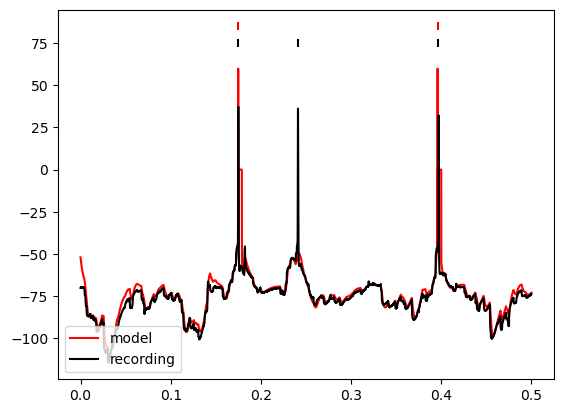

In [29]:

plot_start_time = 0 # s
plot_stop_time = 0.5 # s

plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V_model[int(plot_start_time*20000):int(plot_stop_time*20000)],c='red',label='model')
plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],V_exp[int(plot_start_time*20000):int(plot_stop_time*20000)],c='black',label='recording')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*85,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*75,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()



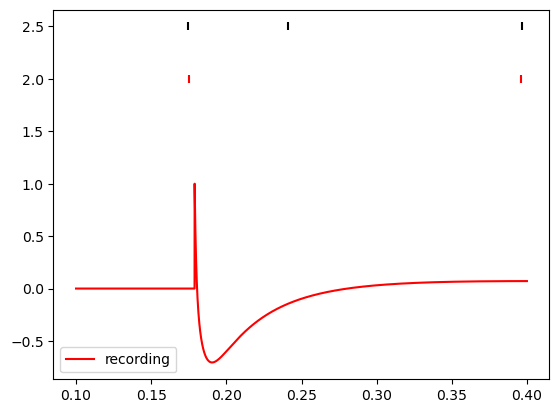

In [28]:

plot_start_time = 0.1 # s
plot_stop_time = 0.4 # s

plt.plot(time[int(plot_start_time*20000):int(plot_stop_time*20000)],I_a[int(plot_start_time*20000):int(plot_stop_time*20000)]/np.max(I_a[int(plot_start_time*20000):int(plot_stop_time*20000)]),c='red',label='recording')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_model[int(plot_start_time*20000):int(plot_stop_time*20000)]*2,c='red' ,marker='|')
plt.scatter(time[int(plot_start_time*20000):int(plot_stop_time*20000)], spks_data[int(plot_start_time*20000):int(plot_stop_time*20000)]*2.5,c='black',marker='|')
plt.legend(loc='lower left')
plt.show()

In [26]:
get_gamma_factor(S_model,spks,4,100*1000,1/20,rate_correction=False)


0.2974452477187436